# GPUの利用

## GPU利用のために必要となる設定

### インスタンスタイプ、VMサイズ

GPUが利用できるEC2インスタンスタイプ(Amazon)、VMサイズ(Microsoft Azure)を指定する必要があります。

Amazon EC2 であれば、以下のものが候補になります。

* [p3インスタンス](https://aws.amazon.com/jp/ec2/instance-types/p3/)
* [p2インスタンス](https://aws.amazon.com/jp/ec2/instance-types/p2/)
* [g3インスタンス](https://aws.amazon.com/jp/ec2/instance-types/g3/)

Microsoft Azure VM であれば、以下のものが候補になります。

* [NVシリーズ](https://docs.microsoft.com/ja-jp/azure/virtual-machines/windows/sizes-gpu#nv-series)

### ドライバ、ライブラリなど

GPUを利用するためには、GPUドライバ、ライブラリなどを準備する必要があります。

VCPではGPUドライバなどをVCノードの構成に合わせた形でセットアップしたものを事前に用意してあります。そのため通常のVCノードを利用する場合に`spec`指定を行ったのと同様の手順で、いくつかのパラメータを `spec`に指定するだけでGPUを利用することが出来ます。

GPUを利用しない場合（下図左側）と、GPUを利用する場合（下図右側）のVCノードの構成を以下に示します。

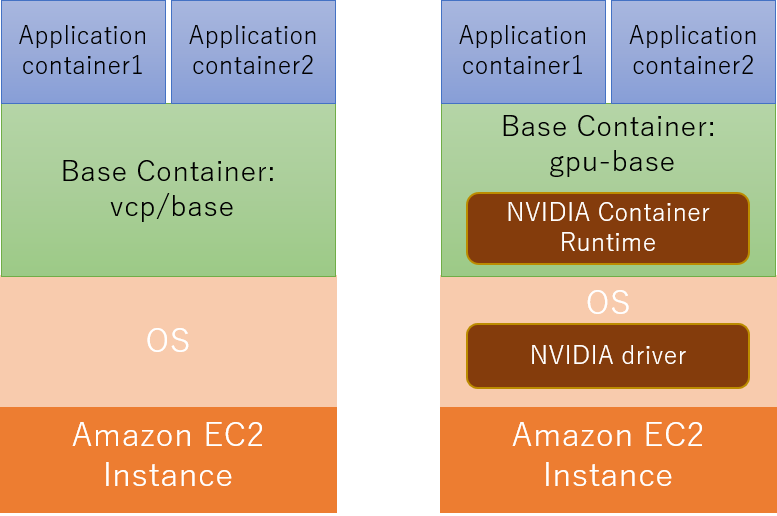

GPUを利用しない場合との違いを以下に示します。
* OS（マシンイメージ）に nvidia ドライバをインストールしている
* Baseコンテナで[NVIDIA Container Runtime for Docker(nvidia-docker)](https://github.com/NVIDIA/nvidia-docker)を利用できるようにセットアップしている

nvidia ドライバはカーネルモジュールになっているため、VMのカーネルバージョンに強く依存しています。そのためnvidiaドライバはBaseコンテナではなくOS（マシンイメージ）にインストールしています。

## 操作手順

この Notebook では以下の操作を行います。

1. GPU用のVCノードを起動する
1. GPUを利用するアプリケーションコンテナを起動する

# GPU用VCノードを起動する

GPUを利用するために必要となるパラメータを `spec`に指定して、VCノードを起動する。

## アクセストークンの入力

VCP SDKを利用するにはVC Controllerのアクセストークンが必要となります。次のセルを実行すると入力枠が表示されるのでアクセストークンの値を入力してください。

In [1]:
from getpass import getpass
vcc_access_token = getpass()

········


## VCP SDKの初期化

VCP SDKの初期化を行います。

In [2]:
from common import logsetting
from vcpsdk.vcpsdk import VcpSDK

# VCの管理オブジェクトの作成
vcp = VcpSDK(
    vcc_access_token,  # VCCのアクセストークン
)

上のセルの実行結果がエラーとなり以下のようなメッセージが表示されている場合は、入力されたアクセストークンに誤りがあります。

```
2018-09-XX XX:XX:XX,XXX - ERROR - config vc failed: http_status(403)
2018-09-XX XX:XX:XX,XXX - ERROR - 2018/XX/XX XX:XX:XX UTC: VCPAuthException: xxxxxxx:token lookup is failed: permission denied
```

この場合はアクセストークンの入力からやり直してください。

## VCノードのspecを指定する

GPUを利用するVCノードのspecを指定します。

GPUを利用するためには`spec`に以下の設定を行う必要があります。

* GPUを利用できるインスタンスタイプを指定する
* GPU用のBaseコンテナイメージを指定する
* GPU用の仮想マシンのイメージを指定する

### specの取得

プロバイダと `flavor`を指定して `spec`オブジェクトを取得します。ここでは以下の値を指定します。

* プロバイダ: `aws`
* flavor: `medium`

> GPUを利用する `flavor` は定義されていないので、後で`spec`オブジェクトに直接インスタンスタイプの指定を行います。

In [3]:
spec = VcpSDK.get_spec(
    'aws',    # プロバイダ
    'medium'  # flavor
)

### インスタンスタイプの設定

GPU を利用できるインスタンスタイプを指定します。

In [4]:
spec.instance_type = 'p2.xlarge'

### Baseコンテナイメージの設定

GPU用のBaseコンテナイメージを`spec`オブジェクトに指定します。

In [5]:
spec.image = 'gpu-base:nvidia-384'

この`gpu-base:nvidia-384`を利用すると、Baseコンテナで[nvidia-docker2](https://github.com/NVIDIA/nvidia-docker)が利用できるようになります。

### 仮想マシンイメージの設定

GPU用の仮想マシンイメージを`spec`オブジェクトに指定します。

In [6]:
spec.cloud_image = 'niivcp-gpu-20180903'

GPUを利用するための nvidiaドライバはカーネルモジュールを含んでいます。そのためnvidiaドライバは仮想マシンのカーネルバージョンに合ったものが必要となります。そこで仮想マシン環境に合ったnvidiaドライバを事前にインストールした仮想マシンイメージを用意しました。ここではその仮想マシンイメージ名を指定しています。

### sshの鍵ファイルを設定する

VCノードにsshでログインするためには事前に公開鍵認証の鍵を VCノードに登録しておく必要があり、そのための設定をここで行います。

VCノードに登録する公開鍵認証の**秘密鍵**のパスを次のセルで設定してください。

In [7]:
import os
ssh_private_key = os.path.expanduser('~/.ssh/id_rsa')

spec に設定が必要となるのは公開鍵なので `ssh-keygen -y` コマンドで秘密鍵から公開鍵を取り出します。さらに公開鍵を`spec`が要求するフォーマット(Base64)に変換して `spec` オブジェクトに設定しています。

In [8]:
out = !ssh-keygen -y -f {ssh_private_key} | base64 -w 0
b64_ssh_public_key = out[0]

# specオブジェクトに設定する
spec.params_e = ['AUTHORIZED_KEYS={}'.format(b64_ssh_public_key)]

### specの設定内容の確認

ここまで `spec` に設定した内容を確認してみます。

In [9]:
print(spec)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: gpu-base:nvidia-384
    recovery_mode: none
    params:
        {'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK'], 'v': []}
    instance_type: p2.xlarge
    volume_size: 40
    volume_type: standard
    volume_id: []
    cloud_image: niivcp-gpu-20180903
    tags: {}


## VCノードの起動

VCノードの起動と、VCノードを操作するためのAnsible設定を行います。

### Unitの作成とVCノードの起動

Unitの作成とVCノードの起動を行います。

まずはUnitGroupを作成します。UnitGroupの名前は `handson201`とします。

In [10]:
unit_group = vcp.create_ugroup(
    'handson201'                   # UnitGroupの名前
)

VCノードを起動する前のUnitとVCノードの状態を確認しておきます。

In [11]:
from IPython.display import display

# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# VCノードの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state


None

Unitの作成とVCノードの起動を行います。

> 処理が完了するまで2分～7分程度かかります。

In [12]:
# Unitの作成（同時に VCノードが作成される）
unit_group.create_unit(
    'gpu',         # Unit名
    spec
)

2018-09-28 15:45:43,908 - INFO - BOOTING ... 0 sec
2018-09-28 15:45:49,113 - INFO - BOOTING ... 5 sec
2018-09-28 15:45:54,309 - INFO - BOOTING ... 10 sec
2018-09-28 15:45:59,494 - INFO - BOOTING ... 15 sec
2018-09-28 15:46:04,680 - INFO - BOOTING ... 20 sec
2018-09-28 15:46:09,867 - INFO - BOOTING ... 25 sec
2018-09-28 15:46:15,068 - INFO - BOOTING ... 30 sec
2018-09-28 15:46:20,275 - INFO - BOOTING ... 35 sec
2018-09-28 15:46:25,485 - INFO - BOOTING ... 40 sec
2018-09-28 15:46:30,694 - INFO - BOOTING ... 45 sec
2018-09-28 15:46:35,896 - INFO - BOOTING ... 50 sec
2018-09-28 15:46:41,104 - INFO - BOOTING ... 55 sec
2018-09-28 15:46:46,316 - INFO - BOOTING ... 60 sec
2018-09-28 15:46:51,518 - INFO - BOOTING ... 65 sec
2018-09-28 15:46:56,731 - INFO - BOOTING ... 70 sec
2018-09-28 15:47:01,930 - INFO - BOOTING ... 75 sec
2018-09-28 15:47:07,139 - INFO - BOOTING ... 80 sec
2018-09-28 15:47:12,347 - INFO - BOOTING ... 85 sec
2018-09-28 15:47:17,559 - INFO - BOOTING ... 90 sec
2018-09-28 15:

起動したUnit, VCノードの一覧を表示します。

In [13]:
# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# VCノードの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,42,handson201,RUNNING,975de972...,2018/09/28 06:44:22 UTC,gpu,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,42,handson201,gpu,RUNNING,1,e3ce219d...,RUNNING,172.30.2.125,i-00c607c9b70af63bb,VCP-020661f0-975de972,none


### Ansible の設定

VCノードの操作には Ansible を用いるので、その設定を行います。

まず、起動したVCノードのIPアドレスをインベントリに登録します。グループ名は `handson201` とします。

In [14]:
# ./hosts に追記する
with open('hosts', 'a') as f:
    f.write("[{}]\n".format(unit_group.name))
    for addr in unit_group.find_ip_addresses():
        f.write("{}\n".format(addr))

# ./hosts の内容を表示する
!cat hosts

[handson201]
172.30.2.125


インベントリの内容は、次のセルを実行すると表示されるリンクから編集することができます。

In [15]:
%run scripts/nbutils.py
nb_html_link(os.path.abspath('hosts'), 'インベントリ')

カレントディレクトリの `hosts`ファイルをインベントリとして ansible が認識するようにする設定を `ansible.cfg`に書き込みます。

In [16]:
if not os.path.exists('ansible.cfg'):
    # ansible.cfgが存在しない場合のみ作成する
    with open('ansible.cfg', 'w') as f:
        f.write('''[defaults]
inventory = {}
'''.format(os.path.abspath('./hosts')))
    
!cat ansible.cfg

[defaults]
inventory = /notebooks/notebook/handson/vcp-tutorial/hosts


VCノードに接続する際のsshの設定を ansible の変数ファイルに格納しておきます。

In [17]:
import yaml

# ansibleでVCノードに接続する際の設定
ansible_params = {
    'ansible_user': 'root',
    'ansible_ssh_extra_args': '-o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null',
    'ansible_ssh_private_key_file': os.path.abspath(ssh_private_key),
}

# group_vars への書き込み
!mkdir -p group_vars
vc_group_vars = os.path.abspath('group_vars/{}.yml'.format(unit_group.name))
with open(vc_group_vars, 'w') as f:
    yaml.dump(ansible_params, stream=f, default_flow_style=False)

!cat {vc_group_vars}

ansible_ssh_extra_args: -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null
ansible_ssh_private_key_file: /home/bit_kun/.ssh/id_rsa
ansible_user: root


疎通確認を行います。

In [18]:
!ansible {unit_group.name} -m ping

172.30.2.125 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


# GPU環境の確認

NVIDIA GPUではGPUデバイスを管理、監視するためのコマンド[nvidia-smi](https://developer.nvidia.com/nvidia-system-management-interface)が提供されています。ここでは、起動したVCノードのGPUに関する状態を取得するために`nvidia-smi`コマンドを実行してみます。

`nvidia-smi` コマンドを利用するとGPU名やドライババージョン、GPUメモリ使用量、GPU使用率、GPUの温度などのGPUに関する情報を取得することができます。`nvidia-smi`コマンドが表示するサマリ情報の例を以下に示します。

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   51C    P0    59W / 149W |      0MiB / 11439MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+
```

`nvidia-smi`コマンドは[CUDAコンテナ](https://hub.docker.com/r/nvidia/cuda/)の中で実行するので、まずコンテナイメージの取得を行います。

> コンテナイメージの取得に１～３分程度かかります。

In [19]:
!ansible {unit_group.name} -a 'docker pull nvidia/cuda:9.0-base'

172.30.2.125 | SUCCESS | rc=0 >>
9.0-base: Pulling from nvidia/cuda
3b37166ec614: Pulling fs layer
504facff238f: Pulling fs layer
ebbcacd28e10: Pulling fs layer
c7fb3351ecad: Pulling fs layer
2e3debadcbf7: Pulling fs layer
328373d1cf96: Pulling fs layer
a9379f1c8963: Pulling fs layer
cc8317b7e8dd: Pulling fs layer
2e3debadcbf7: Waiting
328373d1cf96: Waiting
a9379f1c8963: Waiting
cc8317b7e8dd: Waiting
c7fb3351ecad: Waiting
ebbcacd28e10: Verifying Checksum
ebbcacd28e10: Download complete
504facff238f: Verifying Checksum
504facff238f: Download complete
c7fb3351ecad: Verifying Checksum
c7fb3351ecad: Download complete
2e3debadcbf7: Verifying Checksum
2e3debadcbf7: Download complete
3b37166ec614: Verifying Checksum
3b37166ec614: Download complete
328373d1cf96: Verifying Checksum
328373d1cf96: Download complete
a9379f1c8963: Verifying Checksum
a9379f1c8963: Download complete
cc8317b7e8dd: Verifying Checksum
cc8317b7e8dd: Download complete
3b37166ec614: Pull complete
504facff238f: Pull complet

実際にCUDAコンテナから`nvidia-smi` コマンドを実行してGPUに関するサマリ情報が表示させてみます。

> コンテナを実行する際に`docker run`コマンドの引数に`--runtime=nvidia`オプションを追加しています。このオプションを指定することで、コンテナ内からGPUを利用するための処理が [nvidia-docker2](https://github.com/NVIDIA/nvidia-docker) によって実行されています。

In [20]:
!ansible {unit_group.name} -a 'docker run --runtime=nvidia --rm nvidia/cuda:9.0-base nvidia-smi'

172.30.2.125 | SUCCESS | rc=0 >>
Fri Sep 28 06:49:50 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    80W / 149W |      0MiB / 11439MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                           

GPUに関する詳細情報を取得するために `--query`オプションを指定して `nvidia-smi` コマンドを実行してみます。

> `nvidia-smi`コマンドの他のオプションについては [nvidia-smi documentation](http://developer.download.nvidia.com/compute/DCGM/docs/nvidia-smi-367.38.pdf)を参照してください。

In [21]:
!ansible {unit_group.name} -a 'docker run --runtime=nvidia --rm nvidia/cuda:9.0-base nvidia-smi --query'

172.30.2.125 | SUCCESS | rc=0 >>

==============NVSMI LOG==============

Timestamp                           : Fri Sep 28 06:49:57 2018
Driver Version                      : 384.130

Attached GPUs                       : 1
GPU 00000000:00:1E.0
    Product Name                    : Tesla K80
    Product Brand                   : Tesla
    Display Mode                    : Disabled
    Display Active                  : Disabled
    Persistence Mode                : Disabled
    Accounting Mode                 : Disabled
    Accounting Mode Buffer Size     : 1920
    Driver Model
        Current                     : N/A
        Pending                     : N/A
    Serial Number                   : 0320217038173
    GPU UUID                        : GPU-cdfd3eb7-1561-4d38-f417-431b93da5d08
    Minor Number                    : 0
    VBIOS Version                   : 80.21.1F.00.02
    MultiGPU Board                  : Yes
    Board ID                        : 0x1e
    GPU Part Number    

# GPU環境の利用

## chainerコンテナの実行

[chainer コンテナ](https://hub.docker.com/r/chainer/chainer/)をアプリケーションコンテナとして実行します。

まずコンテナイメージを取得します。

> コンテナイメージの取得に２～３分程度かかります。

In [22]:
!ansible {unit_group.name} -m shell \
    -a 'docker pull  chainer/chainer:v4.4.0-python3'

172.30.2.125 | SUCCESS | rc=0 >>
v4.4.0-python3: Pulling from chainer/chainer
8ee29e426c26: Pulling fs layer
6e83b260b73b: Pulling fs layer
e26b65fd1143: Pulling fs layer
40dca07f8222: Pulling fs layer
b420ae9e10b3: Pulling fs layer
d96ac2114ef0: Pulling fs layer
e1e52a706380: Pulling fs layer
8c519f84b56d: Pulling fs layer
03bdaf98f8ba: Pulling fs layer
44afa2e72753: Pulling fs layer
b9bd6c9f8288: Pulling fs layer
5daa41137c52: Pulling fs layer
5e74e353d49f: Pulling fs layer
b420ae9e10b3: Waiting
03bdaf98f8ba: Waiting
d96ac2114ef0: Waiting
5daa41137c52: Waiting
44afa2e72753: Waiting
e1e52a706380: Waiting
5e74e353d49f: Waiting
8c519f84b56d: Waiting
b9bd6c9f8288: Waiting
40dca07f8222: Waiting
6e83b260b73b: Verifying Checksum
6e83b260b73b: Download complete
e26b65fd1143: Verifying Checksum
e26b65fd1143: Download complete
8ee29e426c26: Verifying Checksum
8ee29e426c26: Download complete
40dca07f8222: Verifying Checksum
40dca07f8222: Download complete
b420ae9e10b3: Verifying Checksum
b420ae

実際に[chainer コンテナ](https://hub.docker.com/r/chainer/chainer/)を実行します。コンテナからGPUを利用するので、先ほどCUDAコンテナを実行した場合と同様に `--runtime=nvidia`オプションを指定します。

In [23]:
!ansible {unit_group.name} -m shell \
    -a 'docker run --runtime=nvidia -td --name chainer --rm \
    -v $HOME/chainer:/opt chainer/chainer:v4.4.0-python3'

172.30.2.125 | SUCCESS | rc=0 >>
07965e90148bacd4f1b0f727ac93cf1583939d06afe094eed37b03c4f42cad8c



## train_mnist.py の実行

[chainer コンテナ](https://hub.docker.com/r/chainer/chainer/)を実行している環境で `train_mnist.py`を実行してみます。

 まず `train_mnist.py` のソースを取得するために https://github.com/chainer/chainer.git のソースツリーを取得します。

In [24]:
!ansible {unit_group.name} -m git \
    -a 'repo=https://github.com/chainer/chainer.git \
    dest=$HOME/chainer version=v4.4.0'

172.30.2.125 | SUCCESS => {
    "after": "d20fb546e255abedb8edc0a93584b290a1a548d2", 
    "before": null, 
    "changed": true, 
    "failed": false
}


`train_mnist.py`を実行するのに必要となるライブラリを chainerコンテナの環境にインストールします。

In [25]:
!ansible {unit_group.name} -a 'docker exec -t chainer pip3 install matplotlib'

172.30.2.125 | SUCCESS | rc=0 >>






















You should consider upgrading via the 'pip install --upgrade pip' command.



`train_mnist.py` を実行します。

> 処理が完了するまで４分～５分程度かかります。

`train_mnist.py`の引数で `--gpu 0` を指定しているのでGPUを利用して処理が実行されています。

In [26]:
!ansible {unit_group.name} -a 'docker exec -t chainer python3 \
    /opt/examples/mnist/train_mnist.py \
    --gpu 0 --noplot --out /opt/output/out'

172.30.2.125 | SUCCESS | rc=0 >>


































































































































































































































































































































































































































































































































[Grafana](/grafana/d/handson/vcp-metrics?refresh=5s)でVCノードの利用状況（CPU、メモリ、ネットワーク）を確認してみます。

> GrafanaでのGPUメトリクス表示は未対応です。

# 後始末

全てのリソースを削除します。

> 処理が完了するまで1分～2分程度かかります。

In [27]:
unit_group.cleanup()

2018-09-28 15:55:41,175 - INFO - gpu is DELETING ... 0 sec
2018-09-28 15:55:46,420 - INFO - gpu is DELETING ... 5 sec
2018-09-28 15:55:51,675 - INFO - gpu is DELETING ... 10 sec
2018-09-28 15:55:56,923 - INFO - gpu is DELETING ... 15 sec
2018-09-28 15:56:02,177 - INFO - gpu is DELETING ... 20 sec
2018-09-28 15:56:07,420 - INFO - gpu is DELETING ... 25 sec
2018-09-28 15:56:12,687 - INFO - gpu is DELETING ... 30 sec
2018-09-28 15:56:17,937 - INFO - gpu is DELETING ... 35 sec
2018-09-28 15:56:23,196 - INFO - gpu is DELETING ... 40 sec
2018-09-28 15:56:28,436 - INFO - gpu is DELETING ... 45 sec
2018-09-28 15:56:33,699 - INFO - gpu is DELETING ... 50 sec
2018-09-28 15:56:38,959 - INFO - gpu is DELETING ... 55 sec
2018-09-28 15:56:44,222 - INFO - gpu is DELETING ... 60 sec
2018-09-28 15:56:49,473 - INFO - gpu is DELETING ... 65 sec
2018-09-28 15:56:54,726 - INFO - gpu is DELETING ... 70 sec
2018-09-28 15:56:59,969 - INFO - gpu is DELETING ... 75 sec
2018-09-28 15:57:05,228 - INFO - gpu is DE

不要になったAnsibleのインベントリファイルを削除します。

In [28]:
!rm hosts